In [43]:
# Joint range between KL and log-L1 over distributions on k items with some bound
import numpy as np
from src.np_utils import vectorized

@vectorized(arg_name=["p", "q"], row_ndim={"p": 1, "q": 1})
def kl_div(p: np.ndarray, q: np.ndarray) -> np.ndarray:
    return np.sum(p * np.log(p / q), axis=-1)

@vectorized(arg_name=["p", "q"], row_ndim={"p": 1, "q": 1})
def log_linf_div(p: np.ndarray, q: np.ndarray) -> np.ndarray:
    return np.max(np.abs(np.log(p) - np.log(q)), axis=-1)

@vectorized(arg_name="p", row_ndim=0)
def bin_to_cat(p: np.ndarray):
    return np.stack([p, 1 - p], axis=-1)

In [74]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def logit(p):
    return np.log(p / (1 - p))

@vectorized(arg_name=["p", "log_linf"], row_ndim={"p": 0, "log_linf": 0})
def binary_log_linf_lb_kl_calc(p: np.ndarray, log_linf: np.ndarray, min_prob: float):
    assert np.all(p >= min_prob) and np.all(p <= 1 - min_prob)

    log_p = np.log(p)
    log_p_tilde = np.log(1-p)
    q_vals = []
    okay_masks = []
    for step, flip in [(log_linf, False), (-log_linf, False), (log_linf, True), (-log_linf, True)]:
        val = 1-p if flip else p
        log_val = np.log(val)
        log_other = log_val + step
        okay_mask = log_other < 0
        other = np.exp(log_other)
        okay_mask &= np.abs(np.log(1 - other) - np.log(1 - val)) <= log_linf
        okay_mask &= (1 - min_prob >= other) & (min_prob <= other)
        q = 1 - other if flip else other

        q_vals.append(q)
        okay_masks.append(okay_mask)
    kl_vals = np.full(p.shape, np.inf)
    for i in range(len(q_vals)):
        q = q_vals[i]
        okay_mask = okay_masks[i]
        if not np.any(okay_mask):
            continue
        okay_q = q[okay_mask]
        okay_p = p[okay_mask]
        kl_vals[okay_mask] = np.minimum(kl_vals[okay_mask], (kl_div(bin_to_cat(okay_p), bin_to_cat(okay_q))))
        # kl_vals[okay_mask] = np.minimum(kl_vals[okay_mask], kl_div(bin_to_cat(okay_q), bin_to_cat(okay_p)))

    return kl_vals

/tmp/ipykernel_29794/3497867271.py:21: RuntimeWarning: invalid value encountered in log
  okay_mask &= np.abs(np.log(1 - other) - np.log(1 - val)) <= log_linf


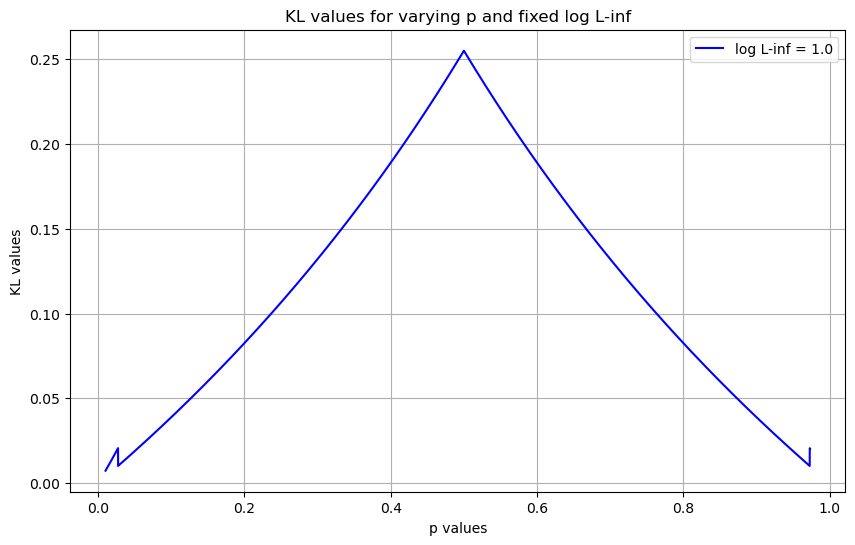

In [75]:
import matplotlib.pyplot as plt

num_points = 10000

# Define a fixed log_l1 value
fixed_log_linf = 1.0
log_linf_values = np.full(num_points, fixed_log_linf)

# Define the range of p values
min_prob = 0.01
p_values = np.linspace(min_prob, sigmoid(logit(1 - min_prob) - fixed_log_linf), num_points)

# Calculate the binary_log_l1_lb_kl values for the range of p values
binary_log_linf_lb_kl_values = binary_log_linf_lb_kl_calc(p_values, log_linf_values, min_prob=min_prob)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(p_values, binary_log_linf_lb_kl_values, 'b-', label=f'log L-inf = {fixed_log_linf}')
plt.xlabel('p values')
plt.ylabel('KL values')
plt.title('KL values for varying p and fixed log L-inf')
plt.legend()
plt.grid(True)
plt.show()

In [76]:
# This gives us a lower bound on KL using log L1 and a min_prob
# Since above func appears to be concave

@vectorized(arg_name="log_linf", row_ndim=0)
def kl_lb_binary_log_linf(log_linf: np.ndarray, min_prob: float) -> np.ndarray:
    min_prob_vals = np.full_like(log_linf, min_prob)
    side_1 = binary_log_linf_lb_kl_calc(min_prob_vals, log_linf, min_prob=min_prob)
    max_prob = 1 - min_prob
    max_prob_vals = np.full_like(log_linf, max_prob)
    side_2 = binary_log_linf_lb_kl_calc(max_prob_vals, log_linf, min_prob=min_prob)

    return np.minimum(side_1, side_2)

In [77]:
import numpy as np

def simplex_meshgrid(k, num_points, min_prob=1e-6, log_space=True):
    """
    Create a meshgrid on the probability simplex with k bins.

    Parameters
    ----------
    k : int
        Number of bins (dimensions).
    num_points : int
        Number of points along each dimension.

    Returns
    -------
    np.ndarray
        Points on the probability simplex.
    """
    def generate_simplex_points(k, num_points, current_sum=0, current_point=None):
        if current_point is None:
            current_point = []
        if 1 - current_sum < min_prob:
            return
        
        if k == 1:
            yield current_point + [1 - current_sum]
        else:
            if log_space:
                values = np.logspace(np.log(min_prob), min(np.log(1 - min_prob), np.log(1 - current_sum)), num_points, base=np.e)
            else:
                values = np.linspace(min_prob, min(1 - min_prob, 1 - current_sum), num_points)
            
            for value in values:
                if current_sum + value <= 1:
                    yield from generate_simplex_points(k - 1, num_points, current_sum + value, current_point + [value])

    points = np.array(list(generate_simplex_points(k, num_points)))
    return points

In [100]:
# First get the joint range between the two for distributions on k items
# Lower bound the probabilities by eps

eps = 0.1
num_points = 1000
k = 2  # Number of items in the distribution

p= simplex_meshgrid(k, num_points, min_prob=eps)
pv, qv = np.broadcast_arrays(p[None], p[:, None])

kl_values = kl_div(pv, qv)
log_linf_values = log_linf_div(pv, qv)

In [101]:
# Get a linspace for the kl value range
log_linf_range = np.linspace(0, np.max(log_linf_values), num_points)
kl_lower_bound_values = kl_lb_binary_log_linf(log_linf_range, eps)


/tmp/ipykernel_29794/3497867271.py:21: RuntimeWarning: invalid value encountered in log
  okay_mask &= np.abs(np.log(1 - other) - np.log(1 - val)) <= log_linf


In [102]:
# # Upper bound on log_l1 using Pinsker's inequality
# @vectorized(arg_name="kl_val", row_ndim=0)
# def log_l1_upper_bound(kl_val: np.ndarray, min_prob: float) -> np.ndarray:
#     return (1 / min_prob) * np.sqrt(2 * kl_val)

# Lower bound KL using log-Linf and Pinsker's inequality
@vectorized(arg_name="log_linf_val", row_ndim=0)
def kl_lower_bound(log_linf_val: np.ndarray, min_prob: float) -> np.ndarray:
    return 0.5 * (min_prob * log_linf_val) ** 2

# @vectorized(arg_name="log_l1_val", row_ndim=0)
# def kl_lower_bound_refined(log_l1_val: np.ndarray, min_prob: float) -> np.ndarray:
#     return 0.5 * (min_prob * log_l1_val) ** 2 + 1/36 * (min_prob * log_l1_val) ** 4 + 1/270 * (min_prob * log_l1_val) ** 6 + 221/340200 * (min_prob * log_l1_val) ** 8

kl_pinsker_lower_bound_values = kl_lower_bound(log_linf_range, eps)

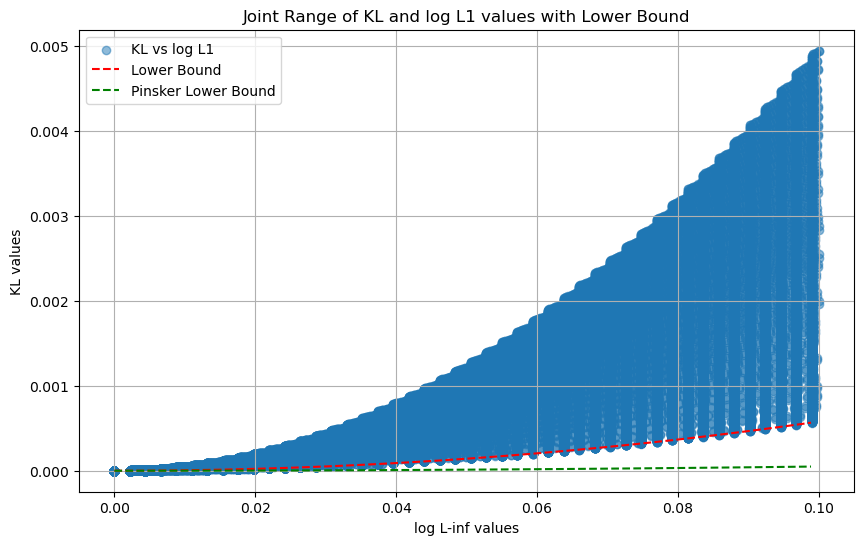

In [103]:
import matplotlib.pyplot as plt

log_linf_bd = 0.1
bded_log_linf_values = log_linf_values[log_linf_values <= log_linf_bd]
bded_kl_values = kl_values[log_linf_values <= log_linf_bd]
bded_log_linf_range = log_linf_range[log_linf_range <= log_linf_bd]
bded_kl_lower_bound_values = kl_lower_bound_values[log_linf_range <= log_linf_bd]
bded_kl_pinsker_lower_bound_values = kl_pinsker_lower_bound_values[log_linf_range <= log_linf_bd]

plt.figure(figsize=(10, 6))
plt.scatter(bded_log_linf_values.flatten(), bded_kl_values.flatten(), alpha=0.5, label='KL vs log L1')
plt.plot(bded_log_linf_range, bded_kl_lower_bound_values, 'r--', label='Lower Bound')
plt.plot(bded_log_linf_range, bded_kl_pinsker_lower_bound_values, 'g--', label='Pinsker Lower Bound')
plt.xlabel('log L-inf values')
plt.ylabel('KL values')
plt.title('Joint Range of KL and log L1 values with Lower Bound')
plt.legend()
plt.grid(True)
plt.show()

[0.05631907 0.05710114 0.05790243]


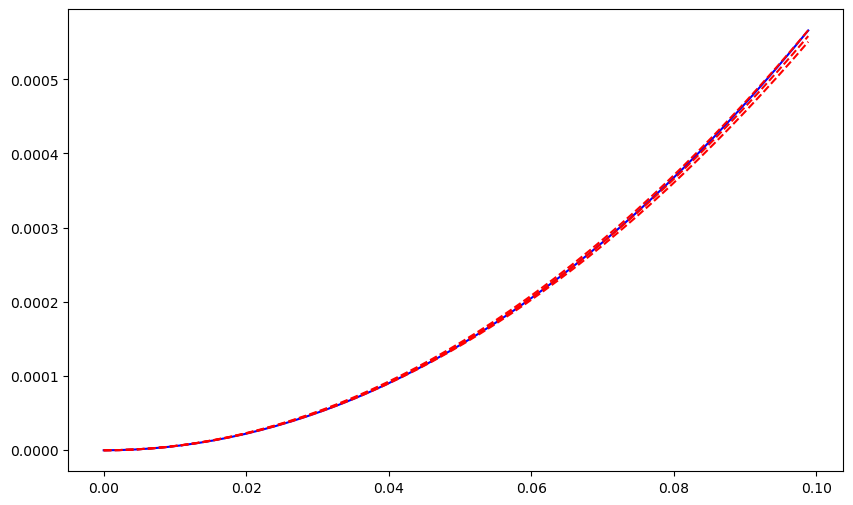

In [104]:
# Fit the KL exact lower bound with a quadratic that only has x^2 coefficient

fit_pts = np.linspace(0, log_linf_bd, 4)[1:]
fit_ys = kl_lb_binary_log_linf(fit_pts, eps)

coeffs = fit_ys / fit_pts ** 2
print(coeffs)

plt.figure(figsize=(10, 6))
plt.plot(bded_log_linf_range, bded_kl_lower_bound_values, 'b-', label='True Lower Bound')
for coeff in coeffs:
    plt.plot(bded_log_linf_range, coeff * bded_log_linf_range ** 2, 'r--', label='Fitted Lower Bound')

In [4]:
# First get the joint range between the two for distributions on k items
# Lower bound the probabilities by eps

eps = 0.001
num_points = 8
k = 5  # Number of items in the distribution

p= simplex_meshgrid(k, num_points, min_prob=eps)
pv, qv = np.broadcast_arrays(p[None], p[:, None])

kl_values = kl_div(pv, qv)
log_linf_values = log_l1_div(pv, qv)



In [5]:
# Get a linspace for the kl value range
log_linf_range = np.linspace(0, np.max(log_linf_values), num_points)
kl_lower_bound_values = kl_lower_bound_refined(log_linf_range, eps)


/home/abhmul/miniforge3/envs/pagi/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


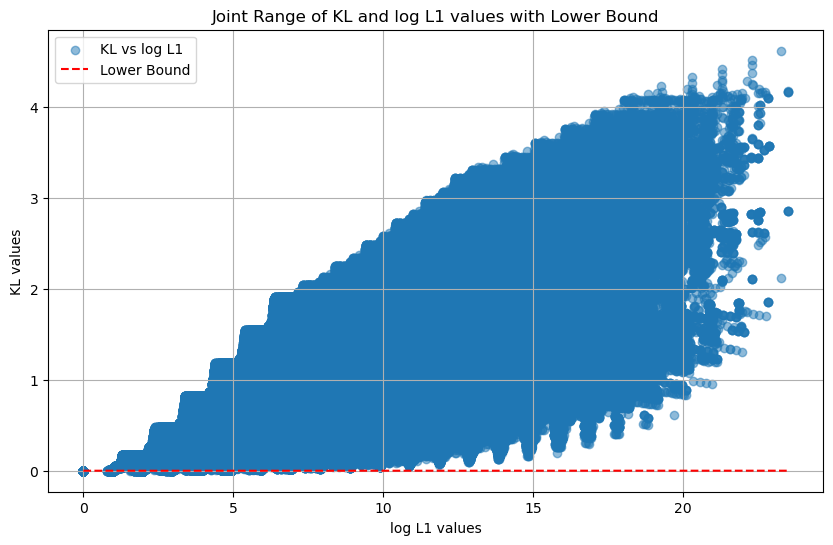

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(log_linf_values.flatten(), kl_values.flatten(), alpha=0.5, label='KL vs log L1')
plt.plot(log_linf_range, kl_lower_bound_values, 'r--', label='Lower Bound')
plt.xlabel('log L1 values')
plt.ylabel('KL values')
plt.title('Joint Range of KL and log L1 values with Lower Bound')
plt.legend()
plt.grid(True)
plt.show()